### MCT - textual componet
The focus in this notebook is the description of relevant exploratoy analyses for a better understanding of the data. We want to investigate the following in relation to the textual component in *MCT*:
* how do to analyse the texts generated by all nodes in $\mathcal{S}_r$ as a corpus and compare with all other nodes?
* the most effective and intuitive way to present/visualise the outputs ...

**Textually-Related Clusters** In LDA, documents or text corpus exhibit multiple topics (interlinked or interrealted, not all the time). A node or user posts many tweets covering wide areas or social aspects that matches closely with what other users are dicsussing. For instance, a *hashtag* can be described as a large corpus consisting of many related and unrelated tweets generated using the hashtag as the *anchor*. The interest here is on *how to capture local communties that are formed based on the discussion topics*? We begin by extracting textual contentfrom nodes/users in the structurally-related category. The basic steps include:
- For each node in the collection i.e. $v_i \in \mathcal{S_r},\mathcal{S_u}$
    - get set of m tweets from each node (as large as possible, making a corpus from the node) such that $$\mathcal{D}_S = \{v_i:[t_{i1},t_{i2},t_{i3}, ... ,t_{im}], v_j:[t_{j1},t_{j2},t_{j3}, ... ,t_{jm}] \} $$ where $\mathcal{D}_S$ is the data whose nodes have been structurally analysed.
- transform text to numeric using the *tfidf-scheme*
- regulise (based on L2 and ) the vectors of each transformed document in the corpus to minimise the coefficients in the corpus
- apply LDA to analyse topics in the corpus
- return the most popular topics in each node's and compare with others in the corpus

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import json, time, re, os
from mlxtend.plotting import ecdf

import tweepy
from tweepy import OAuthHandler, API, Cursor
from datetime import datetime, date, time, timedelta
from collections import Counter
import sys, json, time, string, re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import FreqDist
from scipy.stats import entropy
from scipy.spatial import distance
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import preprocessor as p
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities

In [ ]:
# authentication keys:
access_token = ("USE YOUR ACCESS_TOKEN FROM TWITTER")
access_token_secret = ("USE YOUR ACCESS_TOKEN_SECRET FROM TWITTER")
consumer_key = ("USE YOUR CONSUMER_KEY FROM TWITTER")
consumer_secret = ("USE YOUR CONSUMER SECRET FROM TWITTER")
# authentication instance:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret) # required for validation
auth.set_access_token(access_token, access_token_secret) # required for access after validation of user
api =  tweepy.API(auth) # tweepy requires authenticated user to operate
# with optional parameters ... to avoid service interruption:
#api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [8]:
# begin with structurally related users and collect finite set of tweets:
sr = pd.read_csv('data/mct_structurally_similar_nodes.csv')
#nodes to extract texts from:
all_nodes = sr.Va_ID  
unique_nodes = set(all_nodes) #unique usernames
# use small number of queries not to exceed threshold ... 
users = [i for i in unique_nodes]
len(sr), len(all_nodes),len(users)

(29477, 29477, 1995)

    #use Twitter to extract m-tweets from each node for further analysis ... 

In [ ]:
start = time.time()
visited = []
for user in users:
    if user in visited:
        continue
    visited.append(user)
    try:
        # extract a finite tweets from each node:
        extracts1 = defaultdict(list)
        for item in tweepy.Cursor(api.user_timeline, id=user).items(100):
            extracts1[user].append(item.text)
        # convert the extracts to conform to pandas dataframew:
        extracts2 = {'UserID':[], 'Tweets':[]}
        for k in extracts1.keys():
            extracts2['UserID'].append(k)
            extracts2['Tweets'].append(extracts1[k])
            
        #save extracts:
        dstr = pd.DataFrame(extracts2) 
        with open('data/mct_text_extracts_from_sr_nodes.csv','a') as csv:
            dstr.to_csv(csv, header=False, mode='a', index_label=False)
    
    #mitigate service interruption ....              
    except tweepy.TweepError:
        time.sleep(30 * 15)
        continue
    except StopIteration:
        break
stop = time.time()-start
print('The process took: ',stop/60, ' minutes')
print('no. of actual users: ', len(users))
print('no. of visited users: ', len(visited))

    #LDA dataset and prep

In [9]:
df = pd.read_csv('data/mct_text_extracts_from_sr_nodes.csv')
df.head(3) # see some more samples: df.Tweets.iloc[1]

,UserID,Tweets
0,1093985024171540480,['18 people followed me and 5 people unfollowe...
1,822379141773148161,['RT @alonso_dm: Nunca habría imaginado que er...
2,1048575348907098113,['@foxandfriends So Geraldo knows more about t...


In [10]:
# preprocessing: using custom prepocessing and tweet-preprocessor package
punctuation = list(string.punctuation)
# define a custom stopset:
tweet_stopset = ['rt''rt','\\','via',',',':','.','{}','()','[]','"','"[','-','=','...',']"','[\'\"',',', ']','//','/',\
                 'les','des','de','à','…','la','pour','RT',';','....','……','\'rt\'','&amp;','&amp']
stopset = stopwords.words('english') + punctuation
# additinal function to filter irrelevent content and none content words...
def mopper(x):
    return ' '.join([t.lower() for t in p.clean(x).split() if t not in stopset])#)for t in x.split() if t not in stopset]
# a function to stem tokens in the cleanned text using the Proter's Stemmer:
stemmer = PorterStemmer()
def token_stemmer(text):
    # return the stemmed version of tokens that are greater than 2 in length:
    return ' '.join([stemmer.stem(token) for token in text.split() if len(token)>2])
    #return re.sub("[^a-zA-Z]", "", ' '.join([stemmer.stem(token) for token in text.split() if len(token)>2]))

#retain alphabets only ...
def get_alphabets(text):
    return re.sub("[^a-zA-Z]", " ", text)

In [11]:
# assign a unique and concise ID to each node ... using a short name for ease of operation:
df['ID']= ['V'+str(i) for i in range(len(df))]
# apply the mopper function to clean the tweets for further analysis ... 
df['CleanTweets'] = df.Tweets.apply(lambda x: mopper(x))
# stem tokens using the token_stemmer:
df['CleanTweets'] = df.CleanTweets.apply(lambda x: token_stemmer(x))
#retain alphabets only ... 
df['CleanTweets'] = df.CleanTweets.apply(lambda x: get_alphabets(x))
# tokenisation of the clean tweets to be used by the LDA model:
df['Shingles'] = df.CleanTweets.apply(lambda x: x.split())
df['TweetsLen'] = df.Tweets.apply(lambda x: len([t for t in x.split()]))
df['CleanTweetsLen'] = df.CleanTweets.apply(lambda x: len([t for t in x.split()]))
#save: 
df.to_csv('data/mct_K_tweets_extracts_from_sr_nodes.csv', index_label=False)

In [5]:
#load preprocessed file:
df = pd.read_csv('data/mct_K_tweets_extracts_from_sr_nodes.csv')
# drop documents lessthan a given threshold, i.e if the tokens are less: ... reduced df (rdf)
rdf = df[df.CleanTweetsLen>=700]
rdf = rdf[['ID', 'CleanTweets']]
len(rdf), len(df), len(df.CleanTweets.iloc[1])

(570, 813, 6101)

In [6]:
rdf.head(3)

,ID,CleanTweets
0,V1,de lo nuestros otro a guerracivilista suelt...
0,V3,all this incred accurate this accurate ...
0,V4,lock her up rt too mani politician today ...


In [10]:
#rdf.describe()

**Affinity Matrix:** to store information about relationship between between pairs based on the degree of topical similarity/distribution ... $\mathcal{T}_r \in \mathcal{M}_{tc_{va}}^{m\times m}$

In [8]:
# construction of affinity matrix using the user IDs as columns and index and the entries based on the mean similarity
# between pairs ... first off, empty date frame ... with columns and index based on the union of the users ...
columns = set(df.ID)
index = set(df.ID)
tr_afm =pd.DataFrame(np.zeros(shape=(len(index),len(columns))),columns=columns, index=index)
# update to the matrix is given later ... 
tr_afm.shape

(813, 813)

In [57]:
# empty affinity matrix:
tr_afm.head(3)

,V478,V617,V250,V692,V227,V682,V10,V535,V650,V438,...,V280,V756,V197,V26,V397,V550,V180,V351,V781,V230
V478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


     # Term frequency: topic models such as the LDA is based on the bag of word model (bow)...
    # masking training and testing sets: the mask provides a neat way of splitting the data in the correct proportion

In [9]:
#specify the split proportion ... masked df/rdf for data split -- training and testing sets
mask = np.random.rand(len(rdf)) < 0.75 # boolean to mask and return dataframe where the value is True
# train set:
train_rdf = rdf[mask]
train_rdf.reset_index(drop=True, inplace=True) # reset the index due to offset from masking ...
# test set:
test_rdf = rdf[~mask]
test_rdf.reset_index(drop=True, inplace=True) # reset index ... 
len(df),len(rdf),len(train_rdf),len(test_rdf)

(813, 570, 416, 154)

    #latent themes/topics in all tweets ...
*Using LDA:* Because of high generaton of texts, it will be difficult to view/persepective of the topic, there is a need to represent set of tweets from each node/user and analyse the topics in depth; using a single tweet may not be encompassing, hence the use of aggregate tweets and analyse using LDA. 
The core function of the *LDA* is finding latent variables in the form of *words distributions* and *topics distributions* in a corpus. In this study, the whole tweet corpus is trained such that each document (set of m tweets from each node) will have a *finite distribution over all topics* (and all *topics will have distribution over words*). It is the distribution of each document we are interested in comparing to find the most similar document; hence, only the highest topics in each docment is used for the comparison. 
In LDA, a multidimensional space (as a fuction of the number of topics in the corpora) is used to compare document, such that each document is certain distance away/close to the topics. Each topic/document of the node/user is associated with topics.

In [10]:
# dictionary of the cleaned and tokenised text:
dictionary = corpora.Dictionary([t.split() for t in rdf.CleanTweets]) # a dictionary of terms according to the corpus
# generate a corpus based on the dictinary:
corpus = [dictionary.doc2bow(doc.split()) for doc in rdf.CleanTweets] # list of tuples denoting doc in the data as BOW

    # the bag-of-word model store a numeric representation of a document in which each term is associated with its frequency of occurence; this is normally given as tuple: (3, 7) where '3' is the token id and '7' is the count or frequency of the token/term in the document/corpus.

In [11]:
# the LDA model:
lda = LdaModel(corpus=corpus, num_topics=15, id2word=dictionary, alpha=1e-3,eta=0.5e-3,chunksize=20,\
               minimum_probability=0.0, passes=3)
# see topics learnt by the model and top words in each topic:
lda.show_topics(num_topics=2,num_words=15)

[(7,
  '0.087*"rt" + 0.046*"n" + 0.013*"the" + 0.011*"t" + 0.009*"trump" + 0.008*"you" + 0.006*"amp" + 0.006*"it" + 0.005*"thi" + 0.005*"like" + 0.005*"i" + 0.005*"say" + 0.004*"get" + 0.004*"they" + 0.004*"peopl"'),
 (12,
  '0.828*"nhttps" + 0.076*"site" + 0.050*"plu" + 0.014*"rob" + 0.005*"nhelp" + 0.004*"n" + 0.003*"at" + 0.003*"get" + 0.002*"cbd" + 0.000*"dan" + 0.000*"peopl" + 0.000*"rt" + 0.000*"solution" + 0.000*"well" + 0.000*"le"')]

In [12]:
# showing individual topics for inspection, e.g. inspecting topic 1:
# we can make sense of what topic is based on the top words in the topic ...
lda.show_topic(topicid=1, topn=15)

[('elev', 0.21459636),
 ('clover', 1.6630345e-05),
 ('n', 1.6629592e-05),
 ('the', 1.6627491e-05),
 ('street', 1.6625303e-05),
 ('home', 1.662489e-05),
 ('come', 1.6623913e-05),
 ('rt', 1.6623711e-05),
 ('open', 1.6623662e-05),
 ('new', 1.6623637e-05),
 ('design', 1.662349e-05),
 ('famili', 1.6623484e-05),
 ('welcom', 1.6623477e-05),
 ('day', 1.6623435e-05),
 ('south', 1.6623411e-05)]

In [13]:
# inspecting n topis according to topic id, say 7 topics:
for i in range(1,7):
    print('TOPIC_'+str(i)+':=>',lda.show_topic(topicid=i, topn=15), "\n")

TOPIC_1:=> [('elev', 0.21459636), ('clover', 1.6630345e-05), ('n', 1.6629592e-05), ('the', 1.6627491e-05), ('street', 1.6625303e-05), ('home', 1.662489e-05), ('come', 1.6623913e-05), ('rt', 1.6623711e-05), ('open', 1.6623662e-05), ('new', 1.6623637e-05), ('design', 1.662349e-05), ('famili', 1.6623484e-05), ('welcom', 1.6623477e-05), ('day', 1.6623435e-05), ('south', 1.6623411e-05)] 

TOPIC_2:=> [('via', 0.6472424), ('ad', 0.07462195), ('benefit', 0.07344217), ('well', 0.022859178), ('nat', 0.022079516), ('solut', 0.021466643), ('post', 0.019441694), ('peopl', 0.017609494), ('oil', 0.016286368), ('switch', 0.015354098), ('get', 0.013290652), ('natur', 0.012333833), ('nour', 0.008493414), ('cannabi', 0.0072980933), ('being', 0.004316256)] 

TOPIC_3:=> [('sugar', 0.27472663), ('holli', 0.027853068), ('uni', 1.4799847e-05), ('easi', 1.4790212e-05), ('rt', 1.4777912e-05), ('n', 1.4776108e-05), ('new', 1.4772304e-05), ('now', 1.4769776e-05), ('the', 1.4768427e-05), ('task', 1.4768094e-05), (

*Topics visualisation...*

    # some documents from the corpus for visualisation ... 

In [24]:
# choose a random document from the rdf collection
random_doc_index = np.random.randint(len(test_rdf)) # random doc from test docs
#random_test_doc_index = np.random.randint(len(test_rdf)) # random doc from test docs
# express the document as a bag of word model:
bow = dictionary.doc2bow(train_rdf.iloc[random_doc_index,1].split()) # 1 denotes the text's column in the df:
#topic contributions from the chosen document with random_doc_index
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])
random_doc_index

6

<function matplotlib.pyplot.show(*args, **kw)>

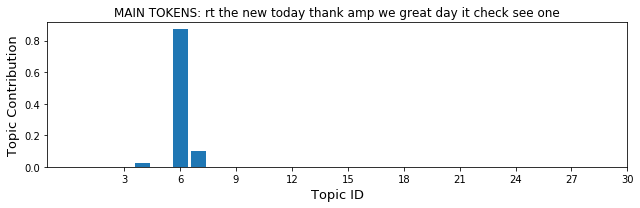

In [26]:
# visualise the output using barplot:
fig, ax = plt.subplots(figsize=(9,3));
patches = ax.bar(np.arange(len(doc_distribution)),doc_distribution)
ax.set_xlabel('Topic ID', fontsize=13)
ax.set_ylabel('Topic Contribution', fontsize=13)
#ax.set_title('Topic Distibution for document ' + str(random_doc_index), fontsize=17)
# use main tokens in the topic as the title:
ax.set_title('MAIN TOKENS: '+' '.join([t[0] for t in lda.show_topic(topicid=random_doc_index, topn=13) if len(t[0])>1]))
ax.set_xticks(np.linspace(3,30,10))
fig.tight_layout()
plt.savefig('results/topic-distribution-for-random-train_document.png',dp1=321)
plt.show

The figure shows that *document 70* contributes five different topics in whcih *topic 23* and *topic 24* (whose meaning are given in the next figure) are more relevant. Each document contributes similar patter of topics and the next **figure** shows more results.

**Topics' contributions** and corresponding words/terms. The output is interpreted to discern/explain the possible theme/subject based on the terms. For instance, document 24 is possibly about the *US Election Interference Investigation* noting the high weigh given to terms/words such as *Trump* and *Muller*

In [27]:
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=7), "\n")

6 [('rt', 0.03314132), ('the', 0.014383931), ('new', 0.010419203), ('today', 0.0090065785), ('thank', 0.008315026), ('amp', 0.008280948), ('we', 0.007649273)] 

7 [('rt', 0.08699513), ('n', 0.045653865), ('the', 0.013029786), ('t', 0.010743319), ('trump', 0.00927815), ('you', 0.0075443625), ('amp', 0.005867165)] 

4 [('n', 0.43248865), ('rt', 0.08064777), ('m', 0.053837277), ('d', 0.035555143), ('l', 0.03412324), ('u', 0.024834676), ('a', 0.021462915)] 

5 [('xa', 0.6717711), ('kong', 0.14213207), ('hong', 0.1317245), ('rt', 1.1828927e-06), ('n', 1.1543988e-06), ('nhttps', 1.1513266e-06), ('d', 1.1511756e-06)] 

14 [('refuge', 0.6648476), ('syrian', 0.22584903), ('priest', 0.022259628), ('cruelti', 0.012287692), ('the', 1.6513967e-06), ('listen', 1.5875232e-06), ('now', 1.5841192e-06)] 



The performance of the *trained LDA model* is evaluated on previously unseen data by comparing the distributions of topics from the set of test data. The evaluation is valid only for terms that appear in the train test (represented in the dictionary created earlier) i.e. previously encountered during the training phase. A term is ignored if it's not encountered earlier. Training the model on a larger and diverse set of data will help in making the model more encompassing.

In [35]:
# get random article from the test set, test_rdf:
random_test_doc_index = np.random.randint(len(test_rdf))
test_doc_bow = dictionary.doc2bow(test_rdf.iloc[random_test_doc_index,1].split()) # numeric transformation of test set:
#test_rdf.iloc[random_test_doc_index,1]
random_test_doc_index

7

In [36]:
# distributions from the random document in the test set: 
test_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=test_doc_bow)])

<function matplotlib.pyplot.show(*args, **kw)>

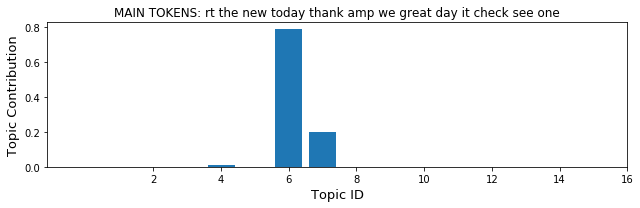

In [54]:
# visuliase distribution from the test document using simialr approach:
fig, ax = plt.subplots(figsize=(9,3));
patches = ax.bar(np.arange(len(test_doc_distribution)), test_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=13)
ax.set_ylabel('Topic Contribution', fontsize=13)
#ax.set_title('Topic Distibution for Test Document ' + str(random_doc_index), fontsize=17)
ax.set_title('MAIN TOKENS: '+' '.join([t[0] for t in lda.show_topic(topicid=random_doc_index, topn=13) if len(t[0])>1]))

ax.set_xticks(np.linspace(2,16,8))
fig.tight_layout()
plt.savefig('results/topic-distribution-for-random-test-document.png',dp1=321)
plt.show

In [55]:
# top terms in the distribution:
for i in test_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=7), "\n")

6 [('rt', 0.03314132), ('the', 0.014383931), ('new', 0.010419203), ('today', 0.0090065785), ('thank', 0.008315026), ('amp', 0.008280948), ('we', 0.007649273)] 

7 [('rt', 0.08699513), ('n', 0.045653865), ('the', 0.013029786), ('t', 0.010743319), ('trump', 0.00927815), ('you', 0.0075443625), ('amp', 0.005867165)] 

4 [('n', 0.43248865), ('rt', 0.08064777), ('m', 0.053837277), ('d', 0.035555143), ('l', 0.03412324), ('u', 0.024834676), ('a', 0.021462915)] 

14 [('refuge', 0.6648476), ('syrian', 0.22584903), ('priest', 0.022259628), ('cruelti', 0.012287692), ('the', 1.6513967e-06), ('listen', 1.5875232e-06), ('now', 1.5841192e-06)] 

13 [('rt', 2.1176593e-05), ('n', 2.1169322e-05), ('the', 2.1165857e-05), ('it', 2.1165062e-05), ('t', 2.1165055e-05), ('thi', 2.1164939e-05), ('you', 2.1164922e-05)] 



In [61]:
test_rdf.iloc[random_test_doc_index,1]

'  dear god  pleas make guidanc clear plain me  might know next step forward  n    concentr god minutes  improv hour follow it  take small god break day   do part uplift others  your smile make immeasur differ someon hurting  allow an   we need pray  need medit allow thought spirit enter minds  must put god first  let neg thought go  watch thought think posit attitude  god forgiv us  practic for   be thank understand god seek insight knowledg regard divin sourc al   god gave everyon guardian angel  the love ask help  ask   n   former wish mani more       repeatedly  confidence  say  feel presenc guardian angel  you least one angel  let knowledg god  love peel away sad uncov innat    n    keep ask guidanc come you  step toward whole alreadi taken  pray     may storm eerienc around planet  help understand storm person lives   n    even pain  look beyond wall find joy sweet knowledg know god love you   when effort successful  give thank it  success meant all us  are separ role impor   pra

In [ ]:
# does users with structurally similarity discuss different topics, what is their topical orientation?

**Comparing document**

To find similarity between the topics/comparing between using each document is given a meaningful fingerprint for comparison. Because each of the document (or the set of tweets from each node) can be represented as a distribution of contributing topics, the distributions of document is compared for assessing the simiarity between documents in the corpus. Each documnet is compared with other documents in the corpuse and the most similar documents to the document (known as the *anchor document*) are returned. 
Given that the comparison is made on probability distribution $p(\cdot)$, the *Jensen-Shannon Divergence* is used to measure the distance between topical themes. The *Jensen-Shannon* is a suitable statistical metric to measure the distance/simialriy between the documents using their distributions. 
For each corpus/document of the user, the model produce the topics and make comparison with other users the JSD is used. 
The divergence in the distirbutions of the document is used to assess simialrity. Proximity is crucial in this case - the closer or similar the document, the less the divergence/distance and vice versa.

***Jensen-Shannon Metric*** is a symmetrical version of the asymmetric *Kullback-Leibler Divergence*. The symmerical property is relevant since the task of comparing two documents should be the same irrespective of the order - A-->B or B-->A should be the same; the *Jensen-Shannon* meets this requirement. Given two discrete distributions $A$ and $B$, the *Jensen-Shannon Divergence (JSD)* is given by/define by $$JS_{divergence}(A||B) = \frac{1}{2}D(A||M) + \frac{1}{2}D(B||M)$$
where $$M = \frac{1}{2}(A+B)$$ denotes the mean of the distributons and the *Kullback-Leibler Divergence D* given by
$$D(A||B) = \sum_i A(i)\log\frac{A(i)}{B(i)}$$
and substituted in **Eq. 1**

$$JS_{divergence}(A||B) = \frac{1}{2}\sum_i\left[A(i)\log\left(\frac{A(i)}{\frac{1}{2}(A(i)+B(i))}\right) + B(i)\log\left(\frac{B(i)}{\frac{1}{2}(A(i)+B(i))}\right)\right]$$

The distance measure of *JSD* is obtained by squaring its divergence relation given by $$JS_{dist} = \sqrt{ \left(JS_{divergence}(A||B \right)}$$

Both $(JS_{divergence}(A||B)$ and $JS_{dist}$ have been computed using the *Scipy implementation* (see https://www.scipy.org/) which is based on the entropy (which calculates the K-L divergence $(JS_{divergence}(A||B)$.)

***Matrix of Values*** In order ro enable faster/efficient computation noting the huge size of the data), all the topics distributions learned by the topic model are represented in a dense matrix $M_{lda}^{m\times k}$. The matrix $M_{lda}^{m\times k}$ of size $M\times K$ is a dense matrix consisting of $M$ number of documents (set of tweets from nodes) and $K$ their corresponding number of *topics*.

In [56]:
# dense matrix creation:
doc_topic_dist = np.array([[tup[1] for tup in t1] for t1 in lda[corpus]])
doc_topic_dist.shape

(570, 15)

In [ ]:
# most similar documents to the achor document constitute the circles or set of textually similar items with the anchor,
#hence belonging to same cluster.

The shape of the matrix, e.g. is 502, 15 i.e. 207 documents and 25 topics. In other words, all the discussions topics in the 207 nodes is within the set of 25 topics and each node may discus from 0 to 25 topics, hence similar nodes will discuss simialr topics. The goal is to identify clsuters with high degree of similarity.

*Helper functions:*
- A function to compute the *JS distance*. The function accepts a *query document* and compare with all other *documents* in the matrix. Because the matrix is an $M \times K$ matrix, the output from issuing the query will return an array of size $M$ i.e. size of the corpus or number of documents in the corpus each with a degree of similarity with the query document. Only the top similar documenst are used in this study.
- A function to return the *indices of top similar documents* in the matrix to the anchor document. The indices can be used to compare/see the returned document by checking the train_rdf for the specific documents. Using the distribution of the random document and all other distributions in the dense matrix using the indices of the most similar docs to the anchor doc are returned.

*Final update to the affinity matrix...*

    # the affinity matrix created earlier is updated according to the degree of similarity in the topical distributions of the respective nodes. The data in the matrix is then used for clustering ... 
    # because the comparison space is huge, ~100k for each comparison, the process is paralellise for efficiency ...

In [ ]:
for v1 in tr_afm.index:
    for v2 in tr_afm.columns:
        # convert to string, tokenise and return list of raw tokens:
        c1=df[df.ID.values==v1].CleanTweets.str.split().tolist()[0]
        c2=df[df.ID.values==v2].CleanTweets.str.split().tolist()[0]
        # documents bag of words ... bow for individual document:
        db1 = dictionary.doc2bow(c1)
        db2 = dictionary.doc2bow(c2)
        # topics distributions in the documents (based on the bow):
        tdist1 = np.array([tup[1] for tup in lda.get_document_topics(bow=db1)])
        tdist2 = np.array([tup[1] for tup in lda.get_document_topics(bow=db2)])
        # compute similarity:
        dsim = np.round(distance.jensenshannon(tdist1, tdist2), 3)
        # assign or populate the affinity matrix:
        tr_afm.loc[v1,v2]=dsim
# save file: tr_afm.to_csv('data/affinity_matrix_of_tr.csv', index_label = False)
tr_afm.shape

In [62]:
tr_afm.shape

(813, 813)

In [59]:
tr_afm.head()

,V478,V617,V250,V692,V227,V682,V10,V535,V650,V438,...,V280,V756,V197,V26,V397,V550,V180,V351,V781,V230
V478,0.000,0.171,0.208,0.248,0.482,0.159,0.595,0.367,0.164,0.531,...,0.338,0.180,0.487,0.374,0.539,0.570,0.392,0.249,0.142,0.160
V617,0.171,NaN,0.227,0.304,0.430,0.076,0.551,0.438,0.143,0.503,...,0.286,0.077,0.433,0.380,0.553,0.527,0.337,0.166,0.229,0.127
V250,0.208,0.227,0.000,0.351,0.424,0.238,0.537,0.473,0.247,0.490,...,0.311,0.210,0.432,0.390,0.539,0.509,0.333,0.239,0.285,0.218
V692,0.248,0.304,0.351,NaN,0.437,0.323,0.535,0.201,0.352,0.460,...,0.323,0.294,0.440,0.243,0.378,0.514,0.372,0.296,0.341,0.250
V227,0.482,0.430,0.424,0.437,0.000,0.485,0.160,0.588,0.536,0.124,...,0.170,0.389,0.023,0.233,0.305,0.124,0.114,0.283,0.591,0.381


**MCT clustering:**
    # having obtain the affinity matrix, the next stage is to apply the MCT algorithm to identify or detect relevant clusters in the network/data.

In [ ]:
########################################################################################################################